In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)
library(devtools)
library(igraph)
library(ggpubr)

# co-expression network analysis packages:
library(WGCNA)
# devtools::install_github('smorabit/hdWGCNA', ref='dev')
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())
})
# set random seed for reproducibility
set.seed(123)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
# load the human TE sample
sample_score <- readRDS("sample_human_TE_EHT.rds")
sample_score

An object of class Seurat 
58840 features across 4158 samples within 2 assays 
Active assay: SCT (21042 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

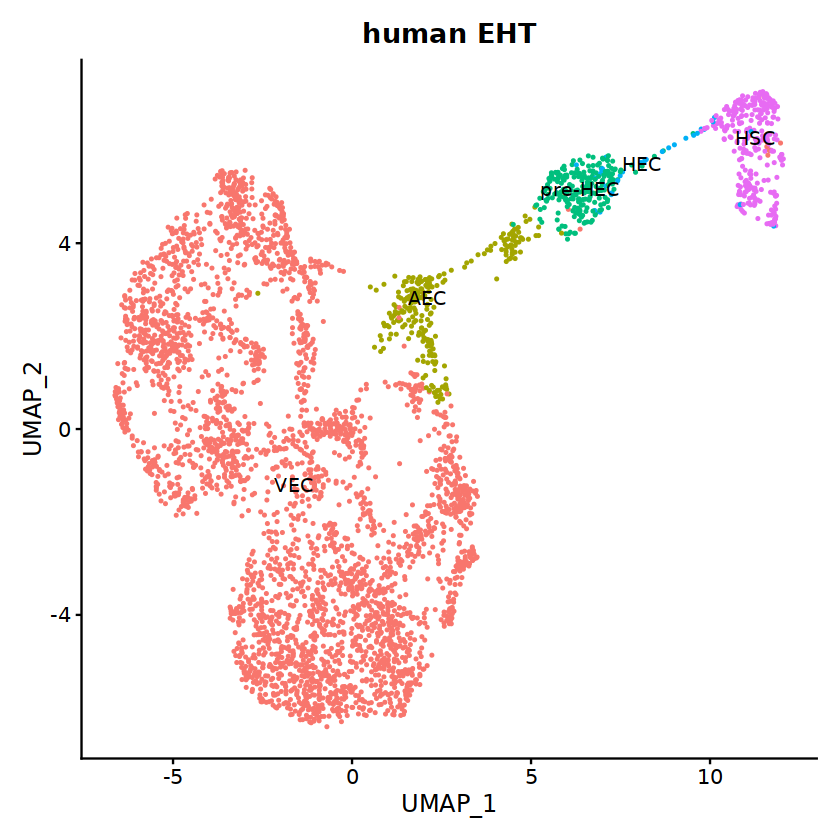

In [3]:
# human EHT umap
DimPlot(sample_score, reduction = "umap", group.by='celltype', label=TRUE) + ggtitle('human EHT') + NoLegend()

In [4]:
# extract celltype marker gene and TE
feature_good <- rownames(sample_score@assays$RNA@counts[which(rowSums(sample_score@assays$RNA@counts) >= 50), ])
TE_genes <- grep(feature_good, pattern = "\\.DNA|\\.SINE|\\.LINE|\\.LTR|SVA", value = T)
length(TE_genes)

celltype_marker_genes <- read.csv("meta/celltype_markers_MAST_human.csv", row.names = 1)
celltype_marker_genes <- subset(celltype_marker_genes, p_val_adj <= 0.05 & avg_log2FC >= 0.5)
celltype_marker_genes <- intersect(feature_good, celltype_marker_genes$gene)
length(celltype_marker_genes)

[1] 988

[1] 528

In [5]:
# setup for hdWGCNA
sample <- SetupForWGCNA(
  sample_score,
  features = c(celltype_marker_genes, TE_genes), # the gene selection approach
  wgcna_name = "EHT" # the name of the hdWGCNA experiment
)
length(sample@misc$EHT$wgcna_genes)

[1] 1516

In [6]:
# construct metacells  in each group
sample <- MetacellsByGroups(
  seurat_obj = sample,
  group.by = c("celltype", "orig.ident"), # specify the columns in seurat_obj@meta.data to group by
  ident.group = 'celltype', # set the Idents of the metacell seurat object
  k = 25, # nearest-neighbors parameter
  reduction = "pca",
  assay = "RNA",
  slot = 'counts',
  max_shared = 10 # maximum number of shared cells between two metacells
)

# normalize metacell expression matrix:
sample <- NormalizeMetacells(sample)

# get the metacell object from the hdWGCNA experiment
metacell_obj <- GetMetacellObject(sample)
metacell_obj

Warning message in MetacellsByGroups(seurat_obj = sample, group.by = c("celltype", :
“Removing the following groups that did not meet min_cells: AEC#Aorta-5wk-555, HEC#Aorta-4wk-658, HEC#Aorta-5wk-555, HEC#Aorta-5wk-575, HSC#Aorta-5wk-555, HSC#Aorta-5wk-575, pre-HEC#Aorta-5wk-555, pre-HEC#Aorta-5wk-575”


An object of class Seurat 
37798 features across 893 samples within 1 assay 
Active assay: RNA (37798 features, 0 variable features)

In [7]:
# extract interested clusters
sample <- SetDatExpr(
  sample,
  group_name = c("VEC","AEC","pre-HEC","HSC"), # the name of the group of interest in the group.by column
  group.by='celltype', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'RNA', # using SCT assay
  use_metacells = TRUE, # use the metacells (TRUE) or the full expression matrix (FALSE)
  slot = 'data' # using normalized data
)

pickSoftThreshold: will use block size 1516.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1516 of 1516


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.33300  7.350          0.936 797.000  7.92e+02  919.0
2      2  0.00929  0.482          0.694 430.000  4.19e+02  590.0
3      3  0.19900 -1.390          0.400 238.000  2.23e+02  399.0
4      4  0.71800 -2.140          0.659 136.000  1.20e+02  283.0
5      5  0.88300 -2.150          0.865  79.700  6.63e+01  212.0
6      6  0.92800 -1.990          0.950  48.600  3.73e+01  167.0
7      7  0.92800 -1.830          0.957  30.900  2.10e+01  136.0
8      8  0.93500 -1.660          0.971  20.500  1.22e+01  113.0
9      9  0.95400 -1.540          0.984  14.100  7.11e+00   97.3
10    10  0.96200 -1.450          0.983  10.200  4.25e+00   85.1
11    12  0.96800 -1.320          0.971   5.940  1.58e+00   68.0
12    14  0.96500 -1.240          0.955   3.900  6.18e-01   56.7
13    16  0.94800 -1.190          0.934   2.790  2.48e-01   48.6
14    18  0.94100 -1.160          0.925   2.110  1.07e-01   42.5
15    20  0.90200 -1.160 

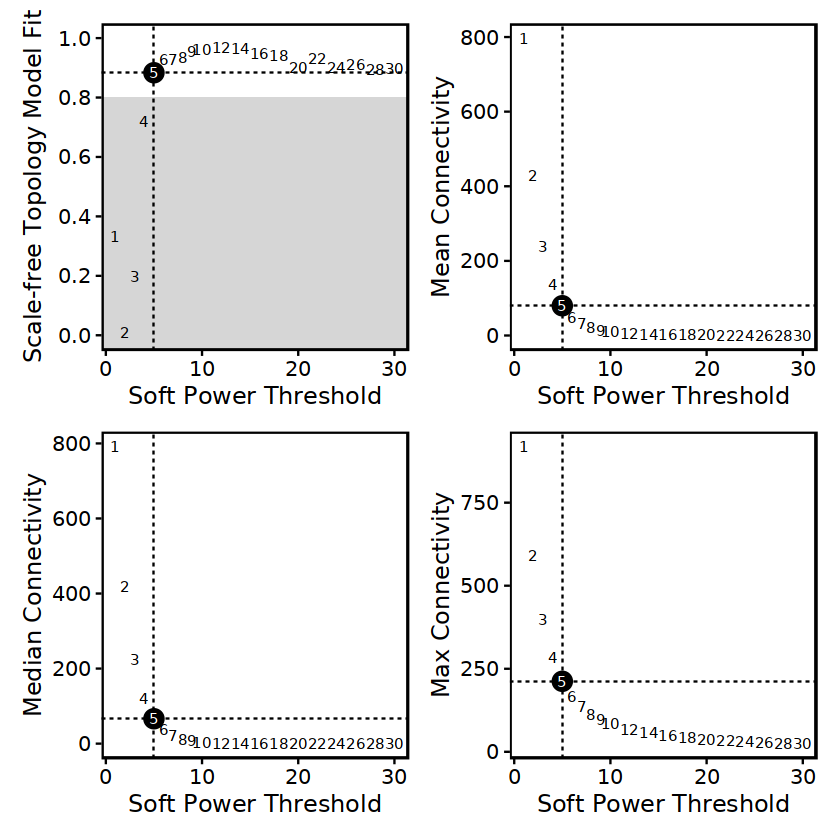

In [8]:
# Test different soft powers:
sample <- TestSoftPowers(
  sample,
  networkType = 'signed',
  setDatExpr=FALSE,
  powers = c(seq(1, 10, by = 1), seq(12, 30, by = 2)))

# plot the results:
plot_list <- PlotSoftPowers(sample, point_size = 5, text_size = 3)
# assemble with patchwork
wrap_plots(plot_list, ncol=2)

Warning message in ConstructNetwork(sample, soft_power = 5, setDatExpr = FALSE, :
“Overwriting TOM TOM/EHT_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


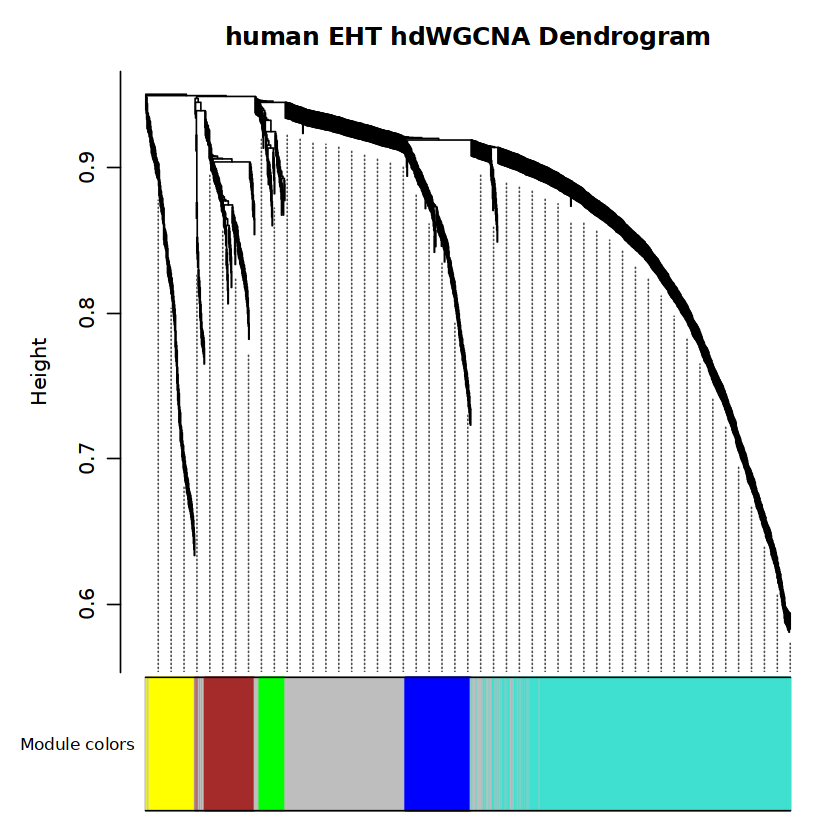

In [9]:
# calculate TOM matrix and cluster genes
sample <- ConstructNetwork(
  sample, 
  soft_power=5,
  setDatExpr=FALSE,
  corType = "pearson",
  networkType = "signed",
  TOMType = "signed",
  detectCutHeight = 0.995,
  minModuleSize = 30,
  mergeCutHeight = 0.2,
  tom_outdir = "TOM",
  overwrite_tom = T,
  tom_name = 'EHT' # name of the topoligical overlap matrix written to disk
)
PlotDendrogram(sample, main='human EHT hdWGCNA Dendrogram')

In [10]:
# need to run ScaleData first or else harmony throws an error:
sample <- ScaleData(sample, features=VariableFeatures(sample))
# compute all MEs in the full single-cell dataset
sample <- ModuleEigengenes(
  sample,
  scale.model.use = "linear", #  choices are "linear", "poisson", or "negbinom"
  pc_dim = 1,
  group.by.vars="orig.ident",
  verbose = FALSE
)

Centering and scaling data matrix



[1] "blue"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is 

[1] "brown"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
Warning message:
“Cannot add objects with duplicate keys (offending key: harmony_), setting key t

[1] "yellow"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object na

[1] "grey"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
Warning message:
“Cannot add objects with duplicate keys (offending key: harmony_), setting key to '

[1] "turquoise"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
Warning message:
“Invalid name supplied, making object name syntactically valid. New 

[1] "green"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clusterscelltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1.2SCT_snn_res.1.5AluX5S.Deu.L2tRNA.DeuhAT.Tip100hAT.BlackjackCR1tRNAhAT.CharliePIF.HarbingerTcMarERV1ERVLDNAL1ERVKTcMar.MarinerTcMar.Tc2L2RTE.XGypsyLTRPiggyBachATTcMar.TiggerTcMar.PogoMIRERVL.MaLRRTE.BovBtRNA.RTEDong.R4MerlinhAT.AcPenelopeMULE.MuDRSVAhAT.Tag1SINEKolobokTcMar.Tc1CryptonI.JockeyL1.Tx1metacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characte

In [11]:
# compute eigengene-based connectivity (kME):
sample <- ModuleConnectivity(
  sample,
  group.by = 'celltype', 
  harmonized = TRUE,
  corFnc = "bicor", # to obtain Pearson correlation
  corOptions = "use='p'", # to obtain Pearson correlation
  assay = NULL,
  slot = "data", # default to normalized 'data' slot
  group_name = c("VEC","AEC","pre-HEC","HSC")
)

# rename the modules
# sample <- ResetModuleNames(
#   sample,
#   new_name = "pre-HEC-"
# )

# print out the new module names
modules <- GetModules(sample)
print(levels(modules$module))

# show the first 6 columns:
head(modules[,1:6])

[1] "blue"      "brown"     "yellow"    "grey"      "turquoise" "green"    


,gene_name,module,color,kME_blue,kME_brown,kME_yellow
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
HES4,HES4,blue,blue,0.72698534,0.36774043,0.05165711
VWA1,VWA1,brown,brown,-0.03489316,0.57780424,-0.11345704
PRDM16-DT,PRDM16-DT,blue,blue,0.58444557,0.04814318,0.12227196
PRDM16,PRDM16,blue,blue,0.48986276,0.06180046,0.15754289
PLOD1,PLOD1,blue,blue,0.24275581,0.18761842,-0.02322216
FBLIM1,FBLIM1,blue,blue,0.28944413,0.12790800,-0.13910696


In [12]:
# get hub genes
hub_df <- GetHubGenes(sample, n_hubs = 10)
head(hub_df)

,gene_name,module,kME
,<chr>,<fct>,<dbl>
1,ADGRG6,blue,0.6889732
2,LTBP4,blue,0.6951839
3,SOX6,blue,0.7053023
4,HEY2,blue,0.7067871
5,IL33,blue,0.7102814
6,HES4,blue,0.7269853


In [13]:
# compute gene scoring for the top 25 hub genes by kME for each module
# with Seurat method
sample <- ModuleExprScore(
  sample,
  n_genes = 25,
  method='Seurat'
)

Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_yellow
Selecting by kME_turquoise
Selecting by kME_green


[1] "blue"
[1] "brown"
[1] "yellow"
[1] "turquoise"
[1] "green"



     blue     brown    yellow      grey turquoise     green 
      155       123       116       387       676        59 

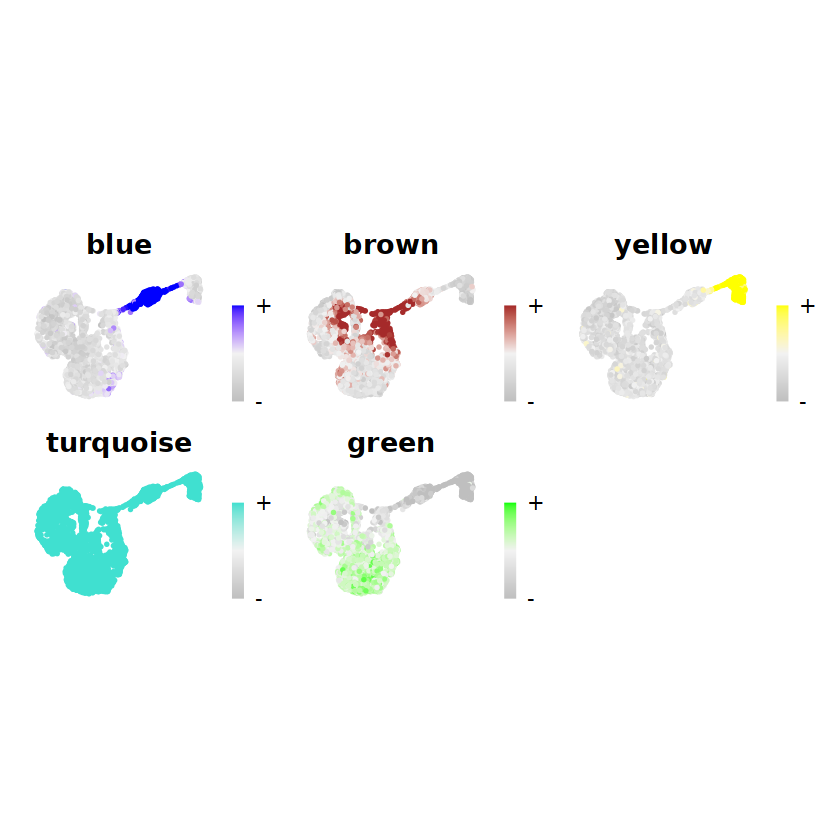

In [14]:
# make a featureplot of hub scores for each module
plot_list <- ModuleFeaturePlot(
  sample,
  features='scores', # plot the hub gene scores
  order='shuffle', # order so cells are shuffled
  ucell = F # depending on Seurat vs UCell for gene scoring
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=3)
table(sample@misc$EHT$wgcna_modules$module)

In [15]:
# get hMEs from seurat object
MEs <- GetMEs(sample, harmonized=TRUE)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
sample@meta.data <- cbind(sample@meta.data, MEs)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


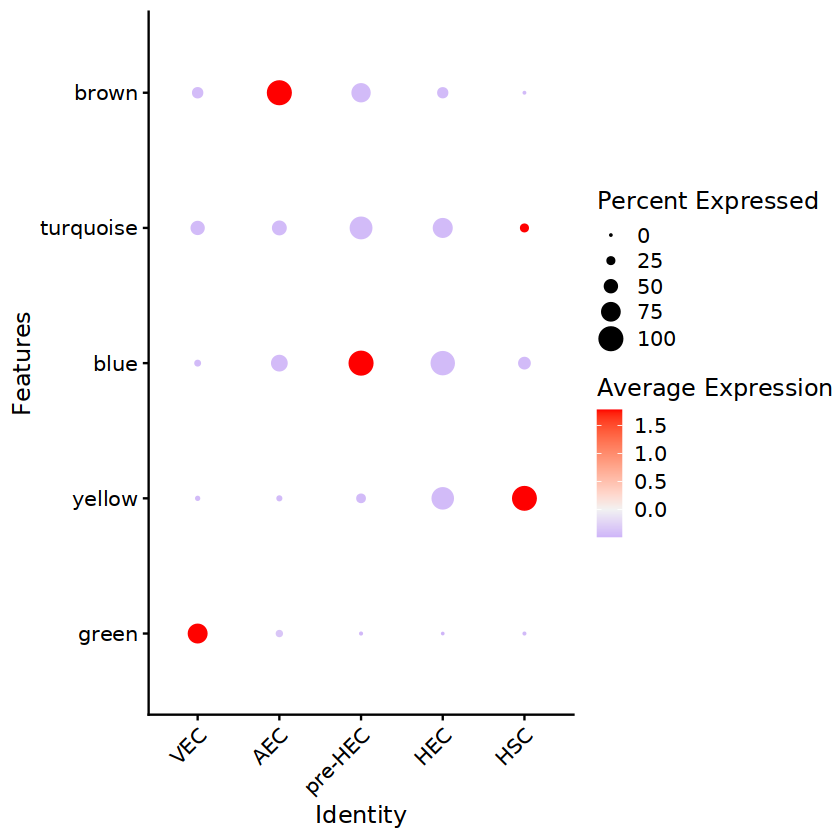

In [16]:
# plot with Seurat's DotPlot function
DotPlot(sample, features=mods, group.by = 'celltype') + coord_flip() + RotatedAxis() + scale_color_gradient2(high='red', mid='grey95', low='blue')

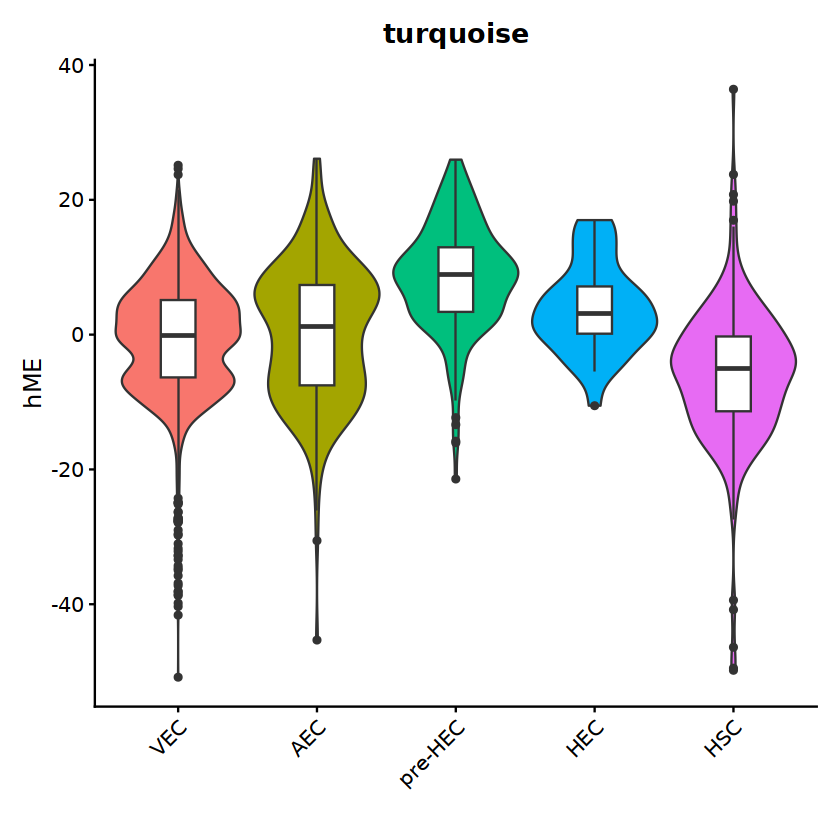

In [17]:
# Plot turquoise hME using Seurat VlnPlot function
p <- VlnPlot(
  sample,
  features = 'turquoise',
  group.by = 'celltype',
  pt.size = 0 # don't show actual data points
)

# add box-and-whisker plots on top:
p <- p + geom_boxplot(width=.25, fill='white')

# change axis labels and remove legend:
p <- p + xlab('') + ylab('hME') + NoLegend()

# plot output
p

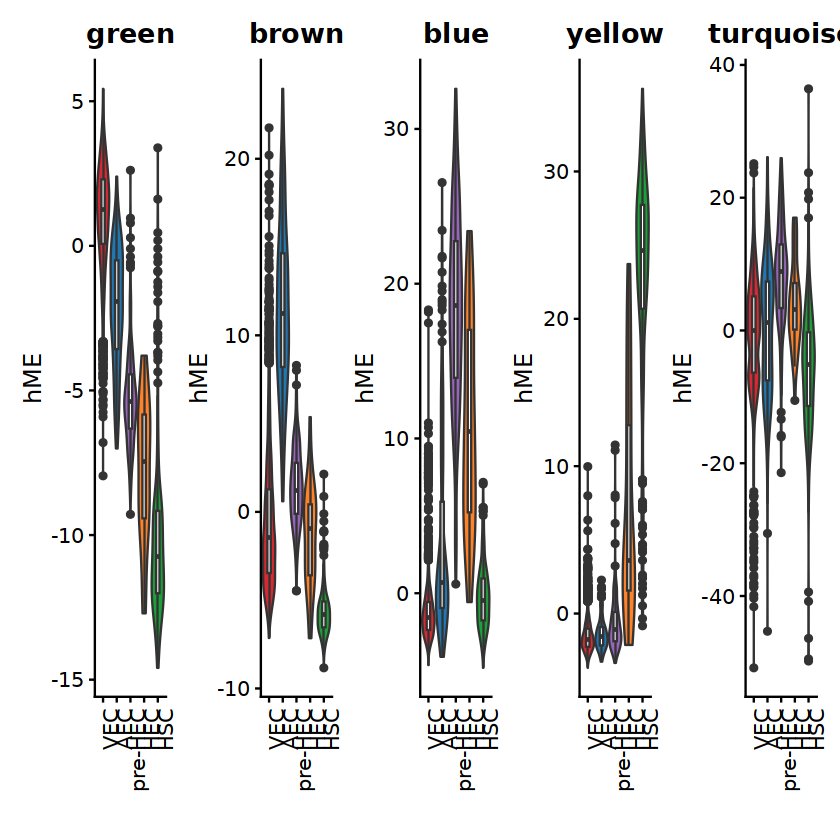

In [18]:
# Plot all hME using Seurat VlnPlot function
mods_vlnplot <- c('green','brown','blue','yellow','turquoise')
plot_list <- lapply(mods_vlnplot, function(x) {
  p <- VlnPlot(
    sample,
    features = x,
    cols = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"),
    group.by = 'celltype',
    pt.size = 0 # don't show actual data points
  )
  
  # add box-and-whisker plots on top:
  p <- p + geom_boxplot(width=.25, fill='white')
  
  # change axis labels and remove legend:
  p <- p + xlab('') + ylab('hME') + NoLegend() + theme(axis.text.x=element_text(angle=90, hjust=1))
  
  p
})
wrap_plots(plot_list, ncol = 5)
ggsave("figure/vlnplot_hME_celltype_human.pdf", width = 15, height = 3.8)

In [19]:
library(igraph)
# Visualizes the top hub genes for selected modules as a circular network plot
ModuleNetworkPlot(
  sample,
  mods = "all", # all modules are plotted.
  outdir = "ModuleNetworks", # The directory where the plots will be stored.
  plot_size = c(6, 6),
  label_center = FALSE,
  edge.alpha = 0.25,
  vertex.label.cex = 1,
  vertex.size = 6
)

Writing output files to ModuleNetworks

Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_yellow
Selecting by kME_turquoise
Selecting by kME_green


[1] "blue"
[1] "brown"
[1] "yellow"
[1] "turquoise"
[1] "green"


Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_yellow
Selecting by kME_turquoise
Selecting by kME_green



     blue     brown    yellow      grey turquoise     green 
        9         9         8         6         9         9 
[1] "blue"      "grey90"    "brown"     "yellow"    "turquoise" "green"    
[1] "here"
[1] 481   4


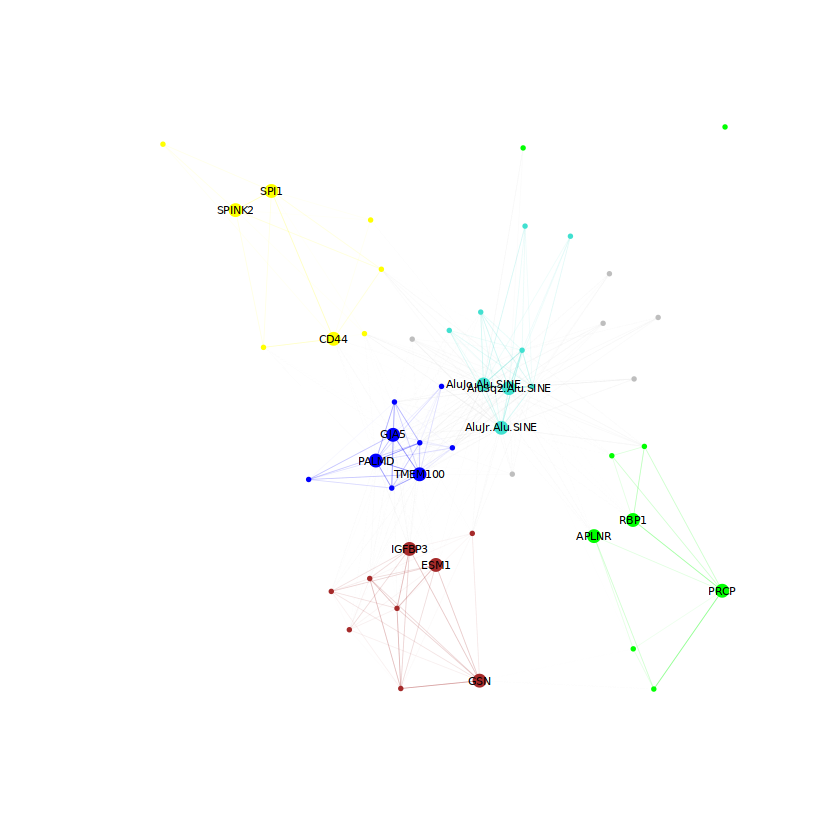

In [20]:
# hubgene network
HubGeneNetworkPlot(
  sample,
  mods = "all", # all modules are plotted.
  n_hubs = 3, 
  n_other=6,
  edge_prop = 0.75,
)

In [21]:
sample <- RunModuleUMAP(
  sample,
  n_hubs = 10, # number of hub genes to include for the UMAP embedding
  n_neighbors=25, # neighbors parameter for UMAP
  min_dist=0.3, # min distance between points in UMAP space
  spread = 1
)

Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_yellow
Selecting by kME_turquoise
Selecting by kME_green


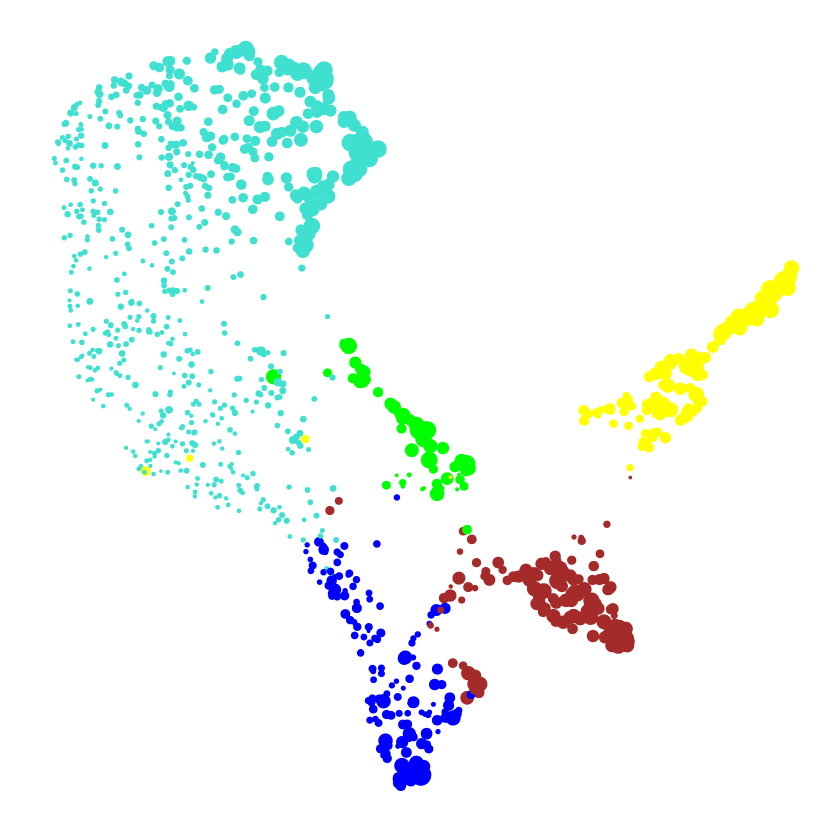

In [22]:
# get the hub gene UMAP table from the seurat object
umap_df <- GetModuleUMAP(sample)

# plot with ggplot with module color
ggplot(umap_df, aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df$color, # color each point by WGCNA module
   size=umap_df$kME*4 # size of each point based on intramodular connectivity
  ) + umap_theme()
ggsave("figure/umap_gene_TE_hdWGCNA_module_human.pdf", width = 5, height = 4)

In [23]:
# link with TE class
umap_df_TE <- umap_df
umap_df_TE$Family <- umap_df$gene

te <- umap_df_TE$Family[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA|\\.SVA")]
umap_df_TE$Family[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA|\\.SVA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(1, 3*length(te), by = 3)]
umap_df_TE$Superfamily <- umap_df_TE$gene
umap_df_TE$Superfamily[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA|\\.SVA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(2, 3*length(te), by = 3)]
umap_df_TE$Class <- umap_df_TE$gene
umap_df_TE$Class[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA|\\.SVA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(3, 3*length(te), by = 3)]
umap_df_TE$Class <- gsub(pattern = "\\?", replacement = "", umap_df_TE$Class)

umap_df_TE$Superfamily[!(umap_df_TE$Class %in% c("LINE","SINE","LTR","DNA","Retroposon"))] <- "Gene"
umap_df_TE$Class[!(umap_df_TE$Class %in% c("LINE","SINE","LTR","DNA","Retroposon"))] <- "Gene"
head(umap_df_TE)
table(umap_df_TE$Class)

,UMAP1,UMAP2,gene,module,color,hub,kME,Family,Superfamily,Class
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
HES4,2.910260,-6.330010,HES4,blue,blue,hub,0.7970285,HES4,Gene,Gene
VWA1,6.621801,-5.000892,VWA1,brown,brown,other,0.8397683,VWA1,Gene,Gene
PRDM16-DT,1.961174,-7.477833,PRDM16-DT,blue,blue,other,0.6158949,PRDM16-DT,Gene,Gene
PRDM16,2.088275,-7.150696,PRDM16,blue,blue,other,0.4957031,PRDM16,Gene,Gene
PLOD1,2.348808,-6.274735,PLOD1,blue,blue,other,0.1816900,PLOD1,Gene,Gene
FBLIM1,1.149818,-4.858193,FBLIM1,blue,blue,other,0.2410195,FBLIM1,Gene,Gene



       DNA       Gene       LINE        LTR Retroposon       SINE 
       164        479        144        277          6         59 

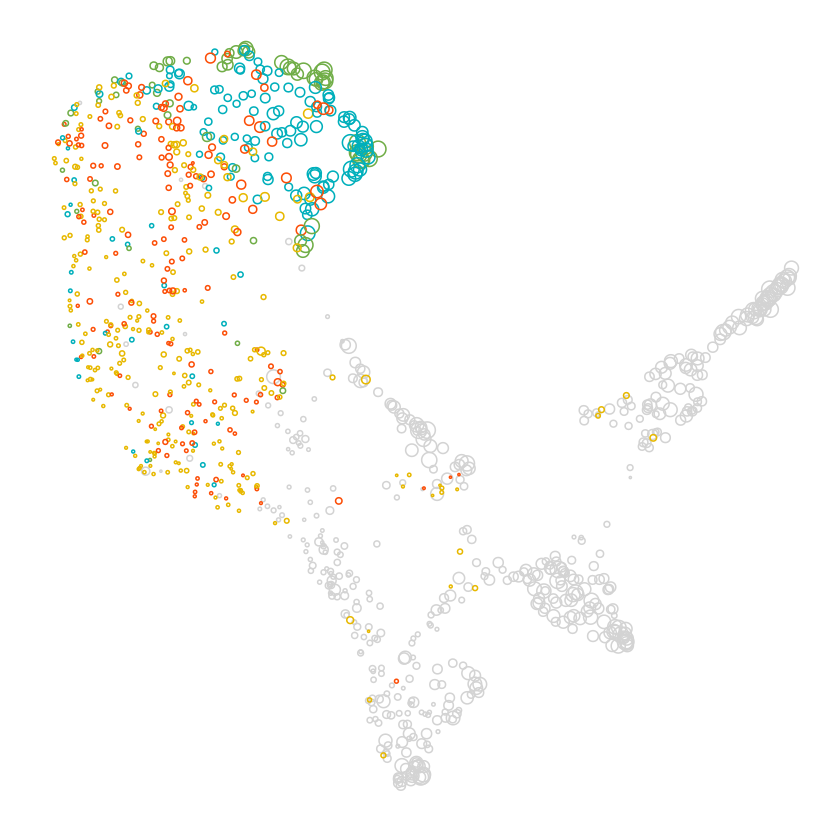

In [24]:
# plot with ggplot with manual color
ggplot(umap_df_TE, aes(x=UMAP1, y=UMAP2, color=Class)) +
  geom_point(size=umap_df_TE$kME*4, shape=1) + theme(legend.position = "none") + scale_color_manual(values = c("#FC4E07", "lightgrey", "#00AFBB", "#E7B800", "#70AD47", "#70AD47")) + umap_theme()
#ggsave("umap_gene_TE_hdWGCNA_human.pdf", width = 5, height = 4)

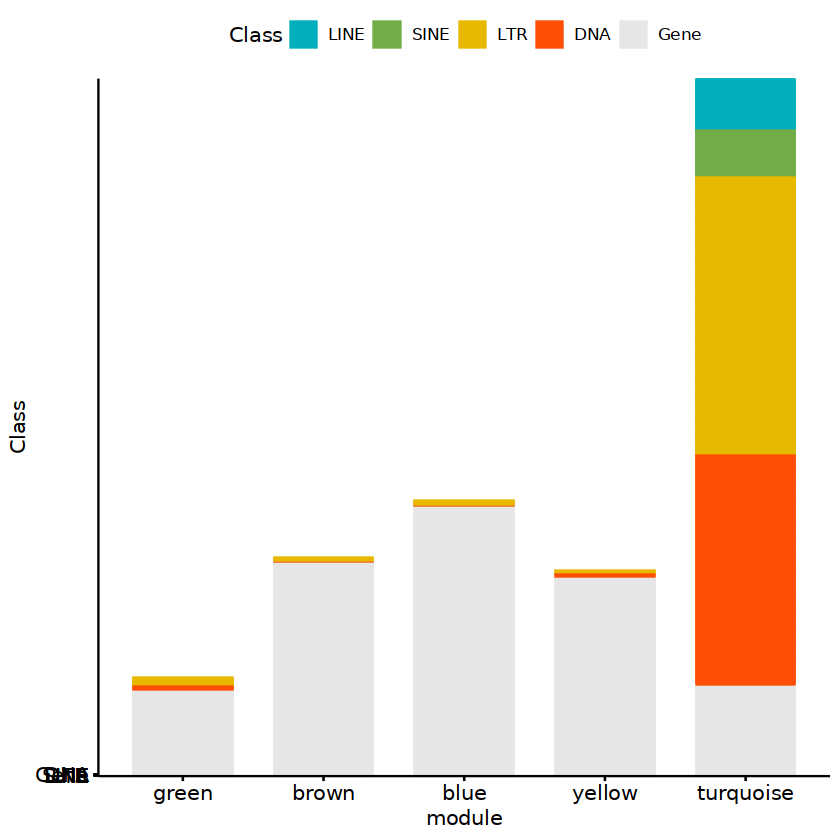

In [25]:
# plot the feature composition in each module
umap_df_TE$Class <- gsub(pattern = "Retroposon", replacement = "SINE", umap_df_TE$Class)
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")
umap_df_TE$Class <- factor(umap_df_TE$Class, levels = c('LINE','SINE','LTR','DNA','Gene'))
umap_df_TE$module <- factor(umap_df_TE$module, levels = c('green','brown','blue','yellow','turquoise'))
ggbarplot(umap_df_TE, "module", "Class", fill = "Class", color = "Class", palette = class_color)
ggsave("figure/class_distribution_module_human.pdf", width = 5, height = 5)

In [26]:
# save the gene umap data
write.csv(umap_df_TE, "meta/umap_df_TE_human.csv")


LINE SINE  LTR  DNA 
 144   65  257  159 

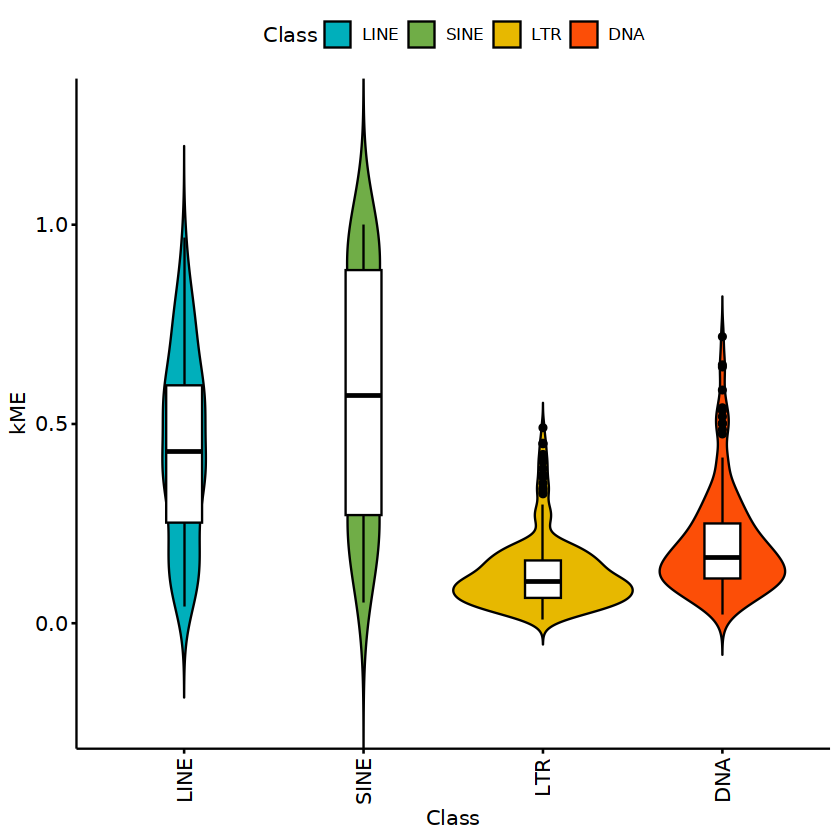

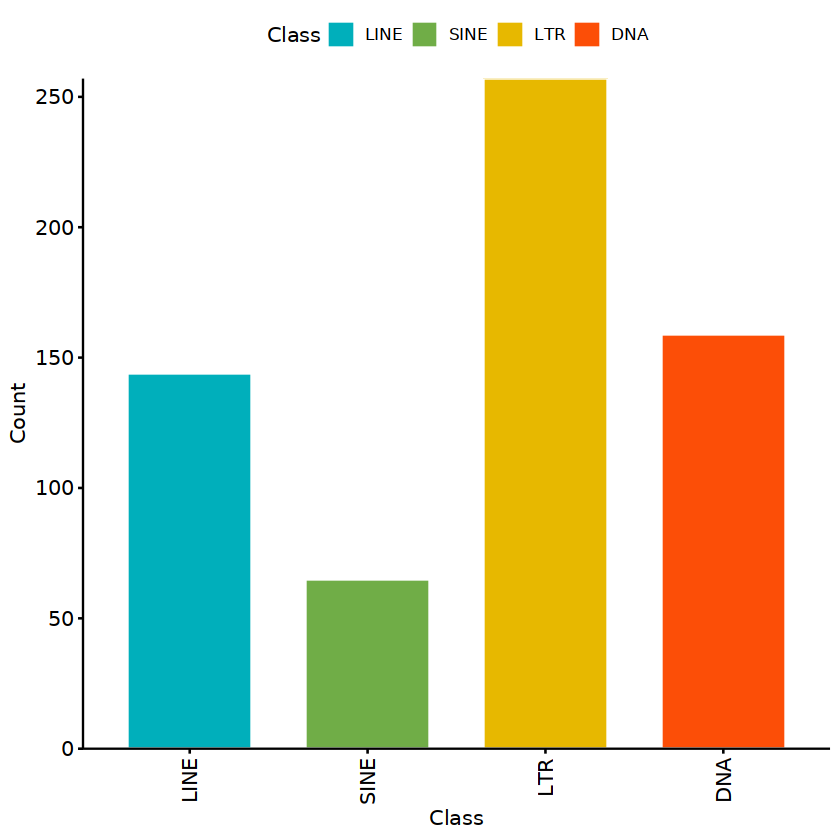

In [27]:
# plot TE composition and kME in HME5
te_module_hg38 <- read.csv("meta/umap_df_TE_human.csv", row.names = 1)
te_module_hg38 <- te_module_hg38[te_module_hg38$module == "turquoise", ]
te_module_hg38 <- te_module_hg38[grep(te_module_hg38$gene, pattern = "\\.DNA|\\.SINE|\\.LINE|\\.LTR|SVA"), ]
te_module_hg38$Class <- factor(te_module_hg38$Class, levels = c("LINE","SINE","LTR","DNA"))
table(te_module_hg38$Class)
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

ggviolin(te_module_hg38, x = "Class", y = "kME",
          fill = "Class",
          palette = class_color,
          sort.val = "none",
          add = "boxplot", add.params = list(fill = "white"),
          x.text.angle = 90
          ) + scale_y_continuous(expand = c(0, 0))
write.csv(te_module_hg38, "te_module_hg38.csv")
ggsave("figure/class_kME_human.pdf", width = 4, height = 5)

module_class_hg38 <- data.frame(table(te_module_hg38$Class))
colnames(module_class_hg38) <- c("Class", "Count")
ggbarplot(module_class_hg38, x = "Class", y = "Count",
          fill = "Class",
          color = "white",
          palette = class_color,
          sort.val = "none",
          x.text.angle = 90
          ) + scale_y_continuous(expand = c(0, 0))
ggsave("figure/class_count_human.pdf", width = 4, height = 5)

Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_yellow
Selecting by kME_turquoise
Selecting by kME_green


[1] "hub labels"
 [1] "PALMD"           "GJA5"            "TMEM100"         "ESM1"           
 [5] "IGFBP3"          "GSN"             "SPINK2"          "CD44"           
 [9] "SPI1"            "AluJo.Alu.SINE"  "AluJr.Alu.SINE"  "AluSq2.Alu.SINE"
[13] "RBP1"            "APLNR"           "PRCP"           
NULL
 [1] "PALMD"           "GJA5"            "TMEM100"         "ESM1"           
 [5] "IGFBP3"          "GSN"             "SPINK2"          "CD44"           
 [9] "SPI1"            "AluJo.Alu.SINE"  "AluJr.Alu.SINE"  "AluSq2.Alu.SINE"
[13] "RBP1"            "APLNR"           "PRCP"           
[1] 56450     3
[1] 0 4


Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `value = scale01(value)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


[1] "making net"
# A tibble: 0 × 5
# Groups:   color [0]
# ℹ 5 variables: Var1 <fct>, Var2 <fct>, value <dbl>, color <chr>,
#   color_alpha <lgl>
          gene_name module color    kME_blue  kME_brown  kME_yellow
VWA1           VWA1  brown brown -0.03489316 0.57780424 -0.11345704
PRDM16-DT PRDM16-DT   blue  blue  0.58444557 0.04814318  0.12227196
PRDM16       PRDM16   blue  blue  0.48986276 0.06180046  0.15754289
PLOD1         PLOD1   blue  blue  0.24275581 0.18761842 -0.02322216
FBLIM1       FBLIM1   blue  blue  0.28944413 0.12790800 -0.13910696
ECE1           ECE1   blue  blue  0.24528144 0.13047418 -0.14517790
              kME_grey kME_turquoise   kME_green    UMAP1     UMAP2   hub
VWA1       0.123137776   -0.10688190  0.01140505 6.621801 -5.000892 other
PRDM16-DT -0.090337477    0.15348125 -0.34899273 1.961174 -7.477833 other
PRDM16    -0.076958393    0.13380029 -0.33115586 2.088275 -7.150696 other
PLOD1      0.030766759    0.03683790 -0.06601799 2.348808 -6.274735 other
FBLIM1  

Warning message in matrix(offset, nrow = 4L, ncol = ncol(x)):
“non-empty data for zero-extent matrix”


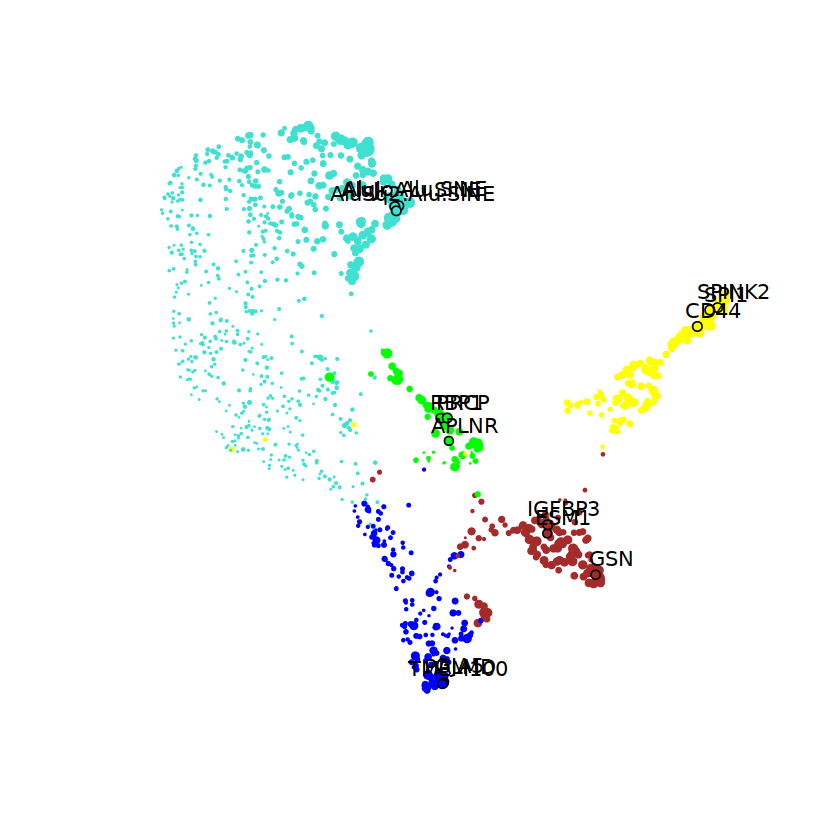

In [28]:
# plot module gene umap
ModuleUMAPPlot(
  sample,
  edge.alpha=0.25,
  sample_edges=TRUE,
  edge_prop=0, # proportion of edges to sample (20% here)
  label_hubs=3 ,# how many hub genes to plot per module?
  keep_grey_edges=FALSE
)

In [29]:
# save the object and export module genes
saveRDS(sample, file = "sample_human_hdWGCNA.rds")
write.csv(sample@misc$EHT$wgcna_modules, "meta/module_hdWGCNA_human.csv")

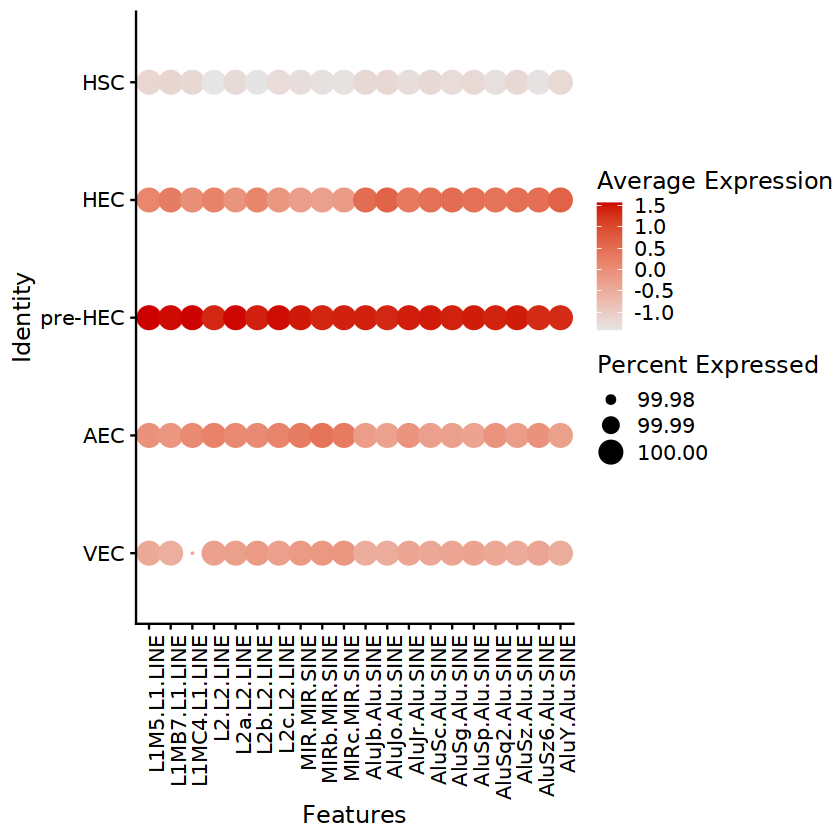

In [30]:
# plot common and specific TE expression
TE_common <- c('L1M5.L1.LINE','L1MB7.L1.LINE','L1MC4.L1.LINE','L2.L2.LINE','L2a.L2.LINE','L2b.L2.LINE','L2c.L2.LINE','MIR.MIR.SINE','MIRb.MIR.SINE','MIRc.MIR.SINE')
TE_human_specific <- c('AluJb.Alu.SINE','AluJo.Alu.SINE','AluJr.Alu.SINE','AluSc.Alu.SINE','AluSg.Alu.SINE','AluSp.Alu.SINE','AluSq2.Alu.SINE','AluSz.Alu.SINE','AluSz6.Alu.SINE','AluY.Alu.SINE')
DotPlot(sample_score, features = c(TE_common, TE_human_specific), cols=c("grey90","red3"), group.by="celltype") + theme(axis.text.x=element_text(angle=90, hjust=1))
#ggsave("module_turquoise_TE_expression_hg38.pdf", width = 11, height = 3.5)

In [31]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] hdWGCNA_0.2.16        WGCNA_1.72-1          fastcluster_1.2.3    
 [4] dynamicTreeCut_1.63-1 ggpubr_0.6.0          igraph_1.4.2         
 [7] devtools_2.4.5        usethis_2.1.6         patchwork_1.1.2      
[10] cowplot_1.1.1         lubridate_1.9.2       forcats_1.0.0        
[13] stringr_1.5.0         dplyr_1.1.1           purrr_1.0.1          
[16] readr_2.1.4           tidyr_1.3.0           tibble_3.2.0 